# ¡Hola, Héctor!  

Mi nombre es Carlos Ortiz, soy code reviewer de TripleTen y voy a revisar el proyecto que acabas de desarrollar.

Cuando vea un error la primera vez, lo señalaré. Deberás encontrarlo y arreglarlo. La intención es que te prepares para un espacio real de trabajo. En un trabajo, el líder de tu equipo hará lo mismo. Si no puedes solucionar el error, te daré más información en la próxima ocasión. 

Encontrarás mis comentarios más abajo - **por favor, no los muevas, no los modifiques ni los borres**.

¿Cómo lo voy a hacer? Voy a leer detenidamente cada una de las implementaciones que has llevado a cabo para cumplir con lo solicitado. Verás los comentarios de esta forma:

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Si todo está perfecto.
</div>


<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Si tu código está bien pero se puede mejorar o hay algún detalle que le hace falta.
</div>


<div class="alert alert-block alert-danger">
    
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
    
Si de pronto hace falta algo o existe algún problema con tu código o conclusiones.
</div>


Puedes responderme de esta forma: 


<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class="tocSkip"></a>
</div>
¡Empecemos!

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Preparación de datos

### Librerías

In [1]:
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt

from re import sub

from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from lightgbm import LGBMRegressor

import warnings

random_state=12345

warnings.simplefilter('ignore')

### Carga de datos

In [2]:
try:
    df = pd.read_csv('car_data.csv')
except:
    df = pd.read_csv('/datasets/car_data.csv')

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Buen trabajo con esta importación de datos y de librerías.
</div>

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


### EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Visualizando la información del dataframe, podemos ver que hay datos ausentes en las columnas: `VehicleType, Gearbox, Model, FuelType, NotRepaired`.
También los nombres de las columnas no están con el formato adecuado para trabajarlas, por lo que es lo primero que haremos con el dataframe

In [5]:
def column_format(c):
    return '_'.join(sub('([A-Z][a-z]+)', r' \1',
                    sub('([A-Z]+)', r' \1',
                    c.replace('-',' '))).split()).lower()

In [6]:
df.columns = [column_format(column) for column in df.columns]

In [7]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Buen trabajo.
</div>

Teniendo las columnas en el formato adecuado, procedemos a analizar los valores ausentes para trabajarlos

In [8]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
mileage                   0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

La columna `number_of_pictures` no es relevante para nuestro modelo, por lo que la desecharemos

In [9]:
df = df.drop('number_of_pictures', axis=1)

In [10]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
mileage                   0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
date_created              0
postal_code               0
last_seen                 0
dtype: int64

En la columna `not_repaired` reemplazaremos los valores ausentes por *unknown*

In [11]:
df['not_repaired'].fillna(value='unknown',inplace=True)

In [12]:
df['vehicle_type'].fillna(value='unknown',inplace=True)

In [13]:
df['fuel_type'].fillna(value='unknown',inplace=True)

In [14]:
df['gearbox'].fillna(value='unknown',inplace=True)

In [15]:
df['model'].fillna(value='unknown',inplace=True)

In [16]:
df.describe()

,price,registration_year,power,mileage,registration_month,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,99998.000000


Se eliminarán los valores ausentes en el resto de las columnas

In [17]:
df.dropna(inplace=True)

In [18]:
df.duplicated().sum()

262

Se eliminan los valores duplicados

In [19]:
df.drop_duplicates(inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354107 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354107 non-null  object
 1   price               354107 non-null  int64 
 2   vehicle_type        354107 non-null  object
 3   registration_year   354107 non-null  int64 
 4   gearbox             354107 non-null  object
 5   power               354107 non-null  int64 
 6   model               354107 non-null  object
 7   mileage             354107 non-null  int64 
 8   registration_month  354107 non-null  int64 
 9   fuel_type           354107 non-null  object
 10  brand               354107 non-null  object
 11  not_repaired        354107 non-null  object
 12  date_created        354107 non-null  object
 13  postal_code         354107 non-null  int64 
 14  last_seen           354107 non-null  object
dtypes: int64(6), object(9)
memory usage: 43.2+ MB


En las columnas `price, power, registration_month` hay valores de *0*, esto no es posible, cada auto en el sitio deberá tener esta información, por lo que para nuestro trabajo eliminaremos esas filas.

In [21]:
df = df[(df['price']!=0) & (df['power']!=0) & (df['registration_month']!=0)]

De acuerdo con la información presentada, el año más grande que se tiene de un auto es del año *9999*, este valor es ilógico ya que nos encontramos en el año 2023, por otra parte el año menor es *1000* siendo que el automovil salió al mercado antes de 1900, por lo que filtraremos los datos entre el año 1900 y 2023.

In [22]:
df = df[(1900 <= df['registration_year']) & (df['registration_year']<=2023)]

In [23]:
df.describe()

,price,registration_year,power,mileage,registration_month,postal_code
count,286847.000000,286847.000000,286847.000000,286847.000000,286847.000000,286847.000000
mean,4977.472412,2003.391383,124.459625,127944.670852,6.380736,51304.390166
std,4630.907071,6.790596,183.680843,36831.279433,3.347734,25741.706387
min,1.000000,1910.000000,1.000000,5000.000000,1.000000,1067.000000
25%,1450.000000,1999.000000,77.000000,125000.000000,4.000000,30989.000000
50%,3300.000000,2004.000000,113.000000,150000.000000,6.000000,50354.000000
75%,7199.000000,2008.000000,150.000000,150000.000000,9.000000,72119.000000
max,20000.000000,2019.000000,20000.000000,150000.000000,12.000000,99998.000000


In [24]:
df.head(3)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
1,24/03/2016 10:58,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,24/03/2016 00:00,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,14/03/2016 00:00,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,91074,17/03/2016 17:40


In [25]:
df = df.drop(['date_crawled','date_created','last_seen','postal_code'],axis=1)

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Buen trabajo en este apartado de la limpieza de datos.
</div>

In [26]:
numeric = ['price','power','mileage']
categoric = ['vehicle_type','gearbox','fuel_type','brand']

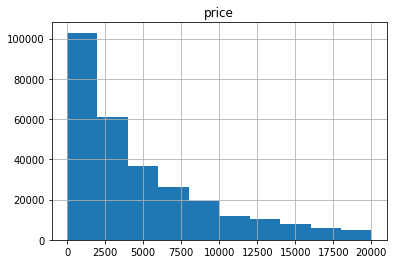

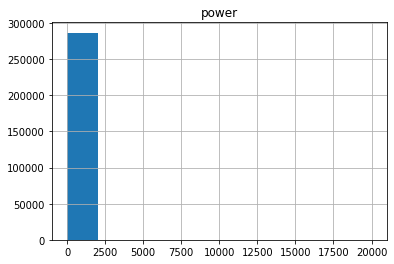

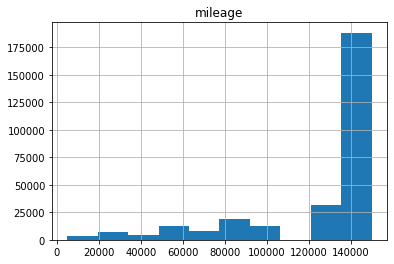

In [27]:
for column in numeric:
    df.hist(column=column, bins=10)
    plt.show()

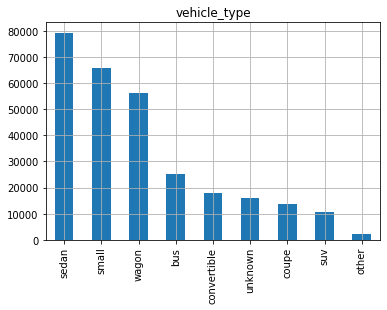

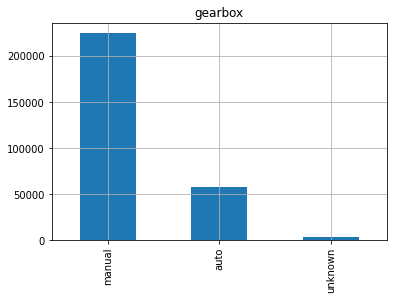

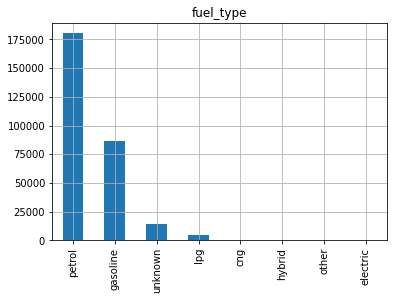

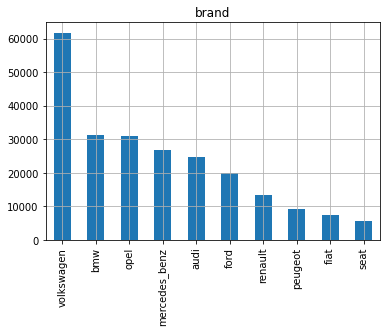

In [28]:
for column in categoric:
    df[column].value_counts().head(10).plot(kind='bar', grid=True, title=column)
    plt.show()

## Entrenamiento del modelo 

### Datasets entrenamiento, prueba

In [29]:
f = df.drop(['price'], axis=1)
t = df['price']

In [30]:
f_ohe = pd.get_dummies(f)

In [31]:
t.shape

(286847,)

In [32]:
f_ohe.shape

(286847, 317)

In [33]:
f_ohe_train, f_ohe_test, t_ohe_train, t_ohe_test = train_test_split(f_ohe, t, test_size=0.3, random_state=random_state)

In [34]:
f_train, f_test, t_train, t_test = train_test_split(f, t, test_size=0.3, random_state=random_state)

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Bien. Todo ha sido corregido.
</div>

### Función evaluación

In [35]:
#def result(pred, target):
 #   mse = mean_squared_error(target, pred)
  #  return mse**0.5
#scorer = make_scorer(result, greater_is_better=False)

#### LightGBM

In [36]:
model = LGBMRegressor()

parameters = {
    'num_leaves': [31, 62,93],
    'learning_rate':[0.1],
    'n_estimators':[10,100],
    'random_state':[random_state]
}

grid = GridSearchCV(estimator=model, param_grid=parameters,scoring='neg_root_mean_squared_error')

grid.fit(f_ohe_train, t_ohe_train)

best_param = grid.best_params_
best_param

{'learning_rate': 0.1,
 'n_estimators': 100,
 'num_leaves': 93,
 'random_state': 12345}

In [37]:
start_lgbm = time.time()

lgbm = LGBMRegressor(learning_rate=0.1, n_estimators=100, num_leaves=93,random_state=random_state)

lgbm.fit(f_ohe_train, t_ohe_train)

finish_fit_lgbm = time.time()

lgbm_pred = lgbm.predict(f_ohe_test)

finish_predict_lgbm = time.time()

In [38]:
lgbm_result = round(mean_squared_error(t_ohe_test, lgbm_pred,squared=False),3)
print(lgbm_result)

lgbmf_time = round(finish_fit_lgbm - start_lgbm,3)
print(lgbmf_time)

lgbmp_time = round(finish_predict_lgbm - start_lgbm,3)
print(lgbmp_time)

1613.764
13.889
15.41


### Árbol de regresión

In [39]:
DTR = DecisionTreeRegressor()

parameters = {
    'max_depth':[10,100],
    'random_state':[random_state]}

grid = GridSearchCV(estimator=DTR, param_grid=parameters,scoring='neg_root_mean_squared_error', cv=3)

grid.fit(f_ohe_train, t_ohe_train)

best_param = grid.best_params_
best_param

{'max_depth': 10, 'random_state': 12345}

In [40]:
start_dtr = time.time()
dtr = DecisionTreeRegressor(max_depth=10, random_state=random_state)

dtr.fit(f_ohe_train, t_ohe_train)

finish_fit_dtr = time.time()

dtr_pred = dtr.predict(f_ohe_test)

finish_predict_dtr = time.time()

In [41]:
dtr_result = round(mean_squared_error(t_ohe_test, dtr_pred,squared=False),3)
print(dtr_result)

dtrf_time = round(finish_fit_dtr - start_dtr,3)
print(dtrf_time)

dtrp_time = round(finish_predict_dtr - start_dtr,3)
print(dtrp_time)

2015.152
4.24
4.346


### Bosque Aleatorio de Regresión

In [42]:
RFR = RandomForestRegressor()

parameters = {
    'max_depth':[2,4],
    'random_state':[random_state]}

grid = GridSearchCV(estimator=RFR, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=3)

grid.fit(f_ohe_train, t_ohe_train)

best_param = grid.best_params_
best_param

{'max_depth': 4, 'random_state': 12345}

In [43]:
start_rfr = time.time()
rfr = RandomForestRegressor(max_depth=4, random_state=random_state)

rfr.fit(f_ohe_train, t_ohe_train)

finish_fit_rfr = time.time()

rfr_pred = rfr.predict(f_ohe_test)

finish_predict_rfr = time.time()

In [44]:
rfr_result = round(mean_squared_error(t_ohe_test, rfr_pred,squared=False),3)
print(rfr_result)

rfrf_time = round(finish_fit_rfr - start_rfr,3)
print(rfrf_time)

rfrp_time = round(finish_predict_rfr - start_rfr,3)
print(rfrp_time)

2685.446
120.198
120.627


### LinearRegressor

In [45]:
start_lrm = time.time()

lrm = LinearRegression()

lrm.fit(f_ohe_train, t_ohe_train)

finish_fit_lrm = time.time()

lrm_pred = lrm.predict(f_ohe_test)

finish_predict_lrm = time.time()

In [46]:
lrm_result = round(mean_squared_error(t_ohe_test, lrm_pred,squared=False),3)
print(lrm_result)

lrmf_time = round(finish_fit_lrm - start_lrm,3)
print(lrmf_time)

lrmp_time = round(finish_predict_lrm - start_lrm,3)
print(lrmp_time)

2776.266
16.559
16.777


## Análisis del modelo

In [47]:
index = ['LGBM','DecisionTreeRegressor','RandomForestRegressor','LinearRegresion']

In [48]:
d = {'rmse':[lgbm_result, dtr_result, rfr_result, lrm_result],
    'time_fitting':[lgbmf_time, dtrf_time, rfrf_time, lrmf_time],
    'time_predicting':[lgbmp_time, dtrp_time, rfrp_time, lrmp_time]}

In [49]:
models = pd.DataFrame(data=d, index=index).sort_values(by='rmse',ascending=True)
models

,rmse,time_fitting,time_predicting
LGBM,1613.764,13.889,15.410
DecisionTreeRegressor,2015.152,4.240,4.346
RandomForestRegressor,2685.446,120.198,120.627
LinearRegresion,2776.266,16.559,16.777


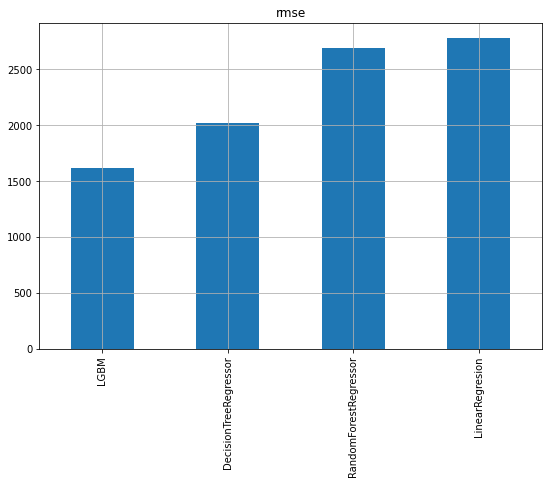

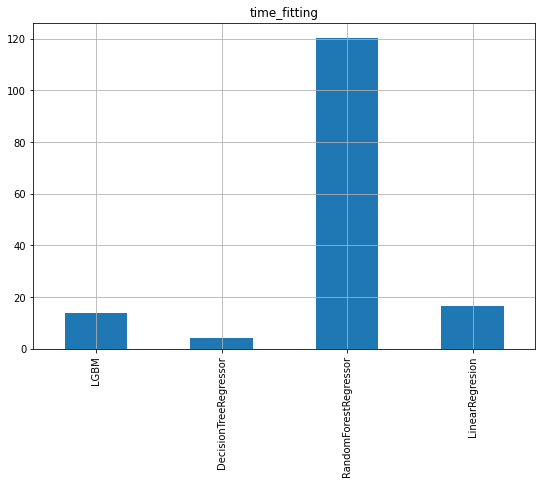

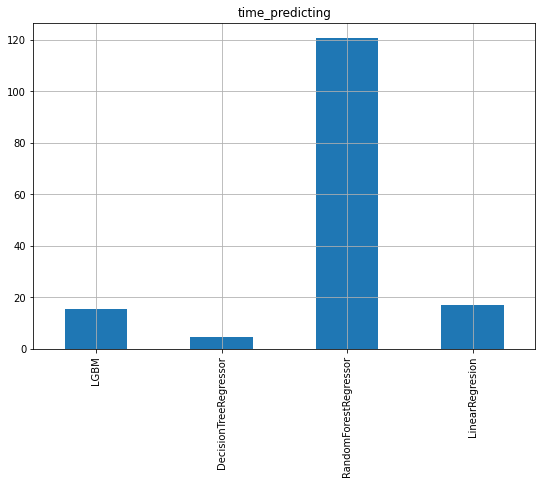

In [50]:
for column in models.columns:
    models[column].plot(kind='bar', figsize=(9,6), title=column, grid=True)
    plt.show()

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Buen trabajo en esta sección. Sin embargo, queda algo de espacio para poder mejorar el modelo de boosting. Incrementa las opciones de hiperparámetros.
</div>

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
¡Perfecto! Es lo que esperamos. Un modelo de boosting siempre debe ser mejor que RF.
</div>

# Conclusiones

El modelo que mejor nos arrojo fue el LGBM, el cual es el que en menor tiempo arroja resultados con nuestros datos.

Se recomienda el uso de este tipo de modelo de regresión para las predicciones de los precios de los autos.

<div class="alert alert-block alert-danger">
    
# Comentarios generales
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Buen trabajo, Héctor. Nos quedan algunos elementos por corregir antes de poder aprobar tu proyecto. He dejado comentarios a lo largo del documento para ello.
</div>

<div class="alert alert-block alert-success">
    
# Comentarios generales
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
¡Todo corregido! Has aprobado un nuevo proyecto.
</div>

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter

- [x]  Jupyter Notebook está abierto
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en orden de ejecución
- [ ]  Los datos han sido descargados y preparados
- [ ]  Los modelos han sido entrenados
- [ ]  Se realizó el análisis de velocidad y calidad de los modelos